In [1]:
import json
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Dense, Embedding,  TimeDistributed
from tensorflow.keras.utils import to_categorical
import zipfile
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras import backend as keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
import time
from dataset_joiner import DatasetWorker, VocabularyWorker
from performance import PerformanceViewer, TrainingEval

In [2]:
np.random.seed(1234567890)

In [3]:
# import data
# specify the type of information which shall be extracted
#extraction_of = 'contexts'
extraction_of = 'sentiments'
#extraction_of = 'aspects'

#sentiment, aspect oder modifier -> diese drei braucht man
#extraktion von polarität nicht gefragt


# specify filenames in the next line
if extraction_of in ['contexts']:
    filename = r'data_laptop_ctxt.json'
elif extraction_of in ['sentiments','aspects']:
    filename = r'data_laptop_absa.json'

## in this example, we use the glove word embeddings as input for the neural network
## download glove.42B.300d.txt from http://nlp.stanford.edu/data/glove.42B.300d.zip
filename_embedding_zip = r'glove.42B.300d.zip' # folder of downloaded glove zip file
## specify folder where to store the glove embeddings
filepath_embedding = filename_embedding_zip.replace('.zip','')
## unzip and save glove to a folder manually or with the next lines
if not os.path.exists(filepath_embedding):
    with zipfile.ZipFile(filename_embedding_zip,"r") as zip_ref:
        zip_ref.extractall(filepath_embedding)
os.listdir(filepath_embedding)[0]
filename_embedding = filepath_embedding + '/' + os.listdir(filepath_embedding)[0]


with open(filename,'r', encoding='utf8') as infile:
    example_data = json.load(infile)


In [4]:
max_seq_length = 100
ds = DatasetWorker(example_data)
ds.applyPreprocessing()
ds.splitDatasetTokens()
ds.setExtractionOf("sentiments")
ds.splitDatasetLabels("union")
ds.buildDatasetSequence(max_seq_length)

tokenize dataset: 3101it [00:00, 71354.32it/s]
split dataset tokens: 3101it [00:00, 1354142.29it/s]
split dataset labels: 3101it [00:00, 111916.92it/s]
update test labels: 100%|██████████| 621/621 [00:00<00:00, 804404.81it/s]


In [5]:
vw = VocabularyWorker()
vw.buildVocabulary(ds.dataset)
vw.buildEmbedding(ds.train_labels)
# Convert data to Input format for neural network
x_train, y_train = vw.convert_tokens_labels_list_to_ids_list(ds.train_tokens, ds.train_labels, max_seq_length)

x_test, y_test = vw.convert_tokens_labels_list_to_ids_list(ds.test_tokens, ds.test_labels, max_seq_length)

Converting tokens & labels to ids : 100%|██████████| 621/621 [00:00<00:00, 40388.00it/s]


In [6]:
#make classes cateogrical
y_train = to_categorical(y_train, num_classes = vw.n_tags)
y_test = to_categorical(y_test, num_classes = vw.n_tags)

In [7]:
# the following two layers should not be changed.
input_layer = Input(shape=(max_seq_length,))
embedding_layer = Embedding(vw.vocab_size, 300, weights=[vw.embedding_vectors], input_length=max_seq_length, trainable= False)(input_layer)

# here, attention models have to be implemented in this model
#nur bestimmten wörtern aufmerksamkeit geben
# ...

# this last layer can/should be modified
output_layer = TimeDistributed(Dense(vw.n_tags, activation="softmax"))(embedding_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["categorical_accuracy", "accuracy"])
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          1452000   
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 3)            903       
Total params: 1,452,903
Trainable params: 903
Non-trainable params: 1,452,000
_________________________________________________________________


In [8]:
performance = PerformanceViewer()
evaluate_callback = TrainingEval(model, x_test, y_test, vw, ds, performance)

In [9]:
# fit model on train data
history = model.fit(
    x_train, y_train,
    batch_size=32,
    #validation_split = 0.2,
    verbose = 1,
    callbacks = [evaluate_callback],
    validation_data=(x_test, y_test),
    epochs=10)

Epoch 1/10
78/78 [==============================] - 0s 5ms/step - loss: 0.1793 - categorical_accuracy: 0.9480 - accuracy: 0.9480 - val_loss: 0.1150 - val_categorical_accuracy: 0.9684 - val_accuracy: 0.9684
Epoch 2/10
78/78 [==============================] - 0s 5ms/step - loss: 0.1062 - categorical_accuracy: 0.9687 - accuracy: 0.9687 - val_loss: 0.1021 - val_categorical_accuracy: 0.9704 - val_accuracy: 0.9704
Epoch 3/10
78/78 [==============================] - 0s 4ms/step - loss: 0.0985 - categorical_accuracy: 0.9695 - accuracy: 0.9695 - val_loss: 0.0961 - val_categorical_accuracy: 0.9707 - val_accuracy: 0.9707
Epoch 4/10
78/78 [==============================] - 0s 5ms/step - loss: 0.0932 - categorical_accuracy: 0.9699 - accuracy: 0.9699 - val_loss: 0.0915 - val_categorical_accuracy: 0.9708 - val_accuracy: 0.9708
Epoch 5/10
78/78 [==============================] - 0s 4ms/step - loss: 0.0892 - categorical_accuracy: 0.9700 - accuracy: 0.9700 - val_loss: 0.0880 - val_categorical_accuracy: 

## Model fit

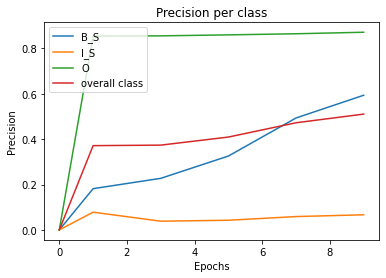

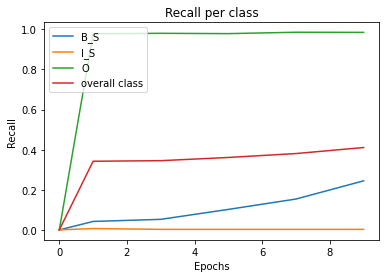

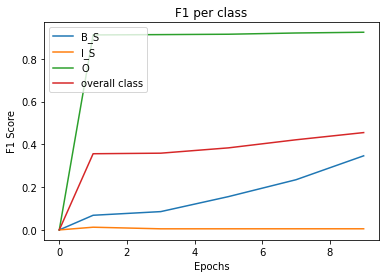

In [10]:
performance.evalModelTrainData()

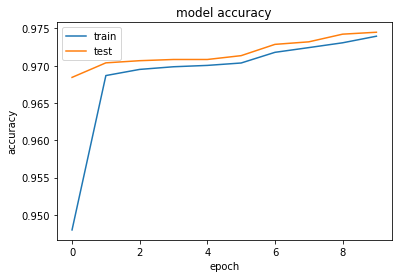

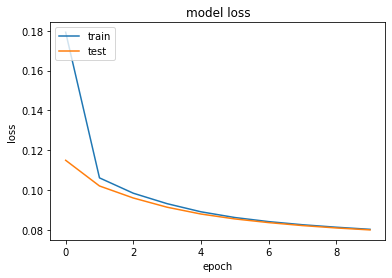

In [11]:
performance.basicEval(history)

In [12]:
performance.classicEval(model, ds,vw,x_test,y_test)

,B_S_pred,I_S_pred,O_pred
B_S_true,232.0,10.0,706.0
I_S_true,33.0,2.0,691.0
O_true,126.0,18.0,9435.0


check gt 0
232.0

CLASS = 0
precision
0.5933503836317136
recall
0.24472573839662448
f1
0.34652725914861837
check gt 0
2.0

CLASS = 1
precision
0.06666666666666667
recall
0.0027548209366391185
f1
0.005291005291005291
check gt 0
9435.0

CLASS = 2
precision
0.8710302806499262
recall
0.9849671155652991
f1
0.9245014942922933

Precision: 0.5103491103161021
Recall: 0.4108158916328542
F1-measure: 0.4552051464286113


